In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


# --- 1. Static Patient Records (The "Files") ---
# Patient ID, Age, Weight (kg), Base Risk Factor (Genetic)
patient_ids = [101, 102, 103, 104, 105]
static_data = pd.DataFrame({
    "Patient_ID": patient_ids,
    "Age": [65, 30, 50, 75, 40],
    "Weight": [80, 70, 95, 60, 85],
    "Genetic_Risk": [1.2, 1.0, 1.1, 1.5, 1.0] # Multiplier for sepsis risk
})

# --- 2. Streaming Sensor Logs (The "Mess") ---
# Sensors fire roughly every minute, but sometimes gap or drift.
sensor_data = []

start_time = pd.Timestamp("2025-01-01 08:00:00")

for pid in patient_ids:
    # Each patient has ~60 minutes of data
    current_time = start_time
    for _ in range(60): 
        # 1. Random Time Drift (Sensors aren't perfect)
        current_time += pd.Timedelta(seconds=np.random.randint(50, 70))
        
        # 2. Simulate Vitals
        # Patient 104 is the "Code Blue" case (Vitals crashing)
        if pid == 104 and _ > 40: 
            hr = np.random.randint(130, 160) # Tachycardia
            o2 = np.random.randint(80, 90)   # Hypoxia
            temp = np.random.uniform(101.0, 104.0) # Fever
        else:
            hr = np.random.randint(60, 100)
            o2 = np.random.randint(95, 100)
            temp = np.random.uniform(98.0, 99.5)

        # 3. Simulate Sensor Failure (NaNs)
        # 10% chance a sensor drops a reading
        if random.random() < 0.1: hr = np.nan 
        if random.random() < 0.1: o2 = np.nan

        sensor_data.append([current_time, pid, hr, o2, temp])

# Convert to DataFrame
logs = pd.DataFrame(sensor_data, columns=["Timestamp", "Patient_ID", "HR", "O2", "Temp"])
logs["Timestamp"] = pd.to_datetime(logs["Timestamp"])
logs.set_index("Timestamp", inplace=True)

logs

,Patient_ID,HR,O2,Temp
Timestamp,,,,
2025-01-01 08:01:01,101,99.0,95.0,99.385912
2025-01-01 08:02:02,101,94.0,98.0,98.670502
2025-01-01 08:03:10,101,78.0,99.0,99.088372
2025-01-01 08:04:11,101,89.0,97.0,98.757222
2025-01-01 08:05:19,101,87.0,NaN,99.311195
...,...,...,...,...
2025-01-01 08:56:22,105,67.0,96.0,99.022688
2025-01-01 08:57:30,105,99.0,99.0,98.011357
2025-01-01 08:58:26,105,82.0,98.0,99.247738


In [174]:
def process_patient(patient_df):
    temp_df = patient_df.drop(columns=["Patient_ID"])
    clean_df = temp_df.resample("1T").mean().interpolate(method="linear")
    return clean_df.dropna()

In [175]:
final_logs =logs.groupby("Patient_ID").apply(process_patient)
final_logs.reset_index()
final_logs.shape
final_logs


C:\Users\Admin\AppData\Local\Temp\ipykernel_5128\70225059.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  clean_df = temp_df.resample("1T").mean().interpolate(method="linear")
C:\Users\Admin\AppData\Local\Temp\ipykernel_5128\70225059.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  clean_df = temp_df.resample("1T").mean().interpolate(method="linear")
C:\Users\Admin\AppData\Local\Temp\ipykernel_5128\70225059.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  clean_df = temp_df.resample("1T").mean().interpolate(method="linear")
C:\Users\Admin\AppData\Local\Temp\ipykernel_5128\70225059.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  clean_df = temp_df.resample("1T").mean().interpolate(method="linear")
C:\Users\Admin\AppData\Local\Temp\ipykernel_5128\7022505

HR    O2       Temp
Patient_ID Timestamp                                 
101        2025-01-01 08:01:00  65.0  97.0  98.635506
           2025-01-01 08:02:00  60.0  97.0  98.304778
           2025-01-01 08:03:00  95.0  97.0  99.012535
           2025-01-01 08:04:00  93.0  97.0  99.121374
           2025-01-01 08:05:00  98.0  97.0  98.517617
...                              ...   ...        ...
105        2025-01-01 08:54:00  66.0  99.0  98.253508
           2025-01-01 08:55:00  73.0  99.0  98.271538
           2025-01-01 08:56:00  89.0  98.0  98.177159
           2025-01-01 08:57:00  95.0  97.5  99.021817
           2025-01-01 08:58:00  74.0  97.0  99.391524

[294 rows x 3 columns]

In [176]:
static_data
final_logs = final_logs.reset_index()

In [177]:
merged_df = pd.merge(final_logs, static_data, on='Patient_ID',how='left')

In [178]:
merged_df

,Patient_ID,Timestamp,HR,O2,Temp,Age,Weight,Genetic_Risk
0,101,2025-01-01 08:01:00,65.0,97.0,98.635506,65,80,1.2
1,101,2025-01-01 08:02:00,60.0,97.0,98.304778,65,80,1.2
2,101,2025-01-01 08:03:00,95.0,97.0,99.012535,65,80,1.2
3,101,2025-01-01 08:04:00,93.0,97.0,99.121374,65,80,1.2
4,101,2025-01-01 08:05:00,98.0,97.0,98.517617,65,80,1.2
...,...,...,...,...,...,...,...,...
289,105,2025-01-01 08:54:00,66.0,99.0,98.253508,40,85,1.0
290,105,2025-01-01 08:55:00,73.0,99.0,98.271538,40,85,1.0
291,105,2025-01-01 08:56:00,89.0,98.0,98.177159,40,85,1.0
292,105,2025-01-01 08:57:00,95.0,97.5,99.021817,40,85,1.0


In [179]:
cols = ["HR", "O2", "Temp"]
for col in cols :
    merged_df[f"{col}_Z"]= (merged_df[col] - merged_df[col].mean()) / merged_df[col].std()


print(merged_df[["HR_Z", "Temp_Z", "O2_Z"]].head())

       HR_Z    Temp_Z      O2_Z
0 -0.943732 -0.315635  0.215134
1 -1.205756 -0.628766  0.215134
2  0.628412  0.041334  0.215134
3  0.523603  0.144383  0.215134
4  0.785627 -0.427251  0.215134


In [180]:
weights = np.array([0.6, 0.3, -0.5])

In [181]:
risk_matrix = merged_df[["HR_Z", "Temp_Z", "O2_Z"]].values


In [182]:
merged_df["Base_Score"] = risk_matrix @ weights

In [183]:
merged_df["Total_Risk"]= merged_df["Base_Score"] * merged_df["Genetic_Risk"]

In [184]:
merged_df.head()

,Patient_ID,Timestamp,HR,O2,Temp,Age,Weight,Genetic_Risk,HR_Z,O2_Z,Temp_Z,Base_Score,Total_Risk
0,101,2025-01-01 08:01:00,65.0,97.0,98.635506,65,80,1.2,-0.943732,0.215134,-0.315635,-0.768497,-0.922196
1,101,2025-01-01 08:02:00,60.0,97.0,98.304778,65,80,1.2,-1.205756,0.215134,-0.628766,-1.019651,-1.223581
2,101,2025-01-01 08:03:00,95.0,97.0,99.012535,65,80,1.2,0.628412,0.215134,0.041334,0.281880,0.338257
3,101,2025-01-01 08:04:00,93.0,97.0,99.121374,65,80,1.2,0.523603,0.215134,0.144383,0.249909,0.299891
4,101,2025-01-01 08:05:00,98.0,97.0,98.517617,65,80,1.2,0.785627,0.215134,-0.427251,0.235633,0.282760


In [185]:
critical_patients = merged_df.sort_values("Total_Risk", ascending=False)

In [186]:
top_patient = critical_patients.iloc[0]
patient_id = int(top_patient["Patient_ID"])
crash_time = top_patient["Timestamp"]
risk_score = top_patient["Total_Risk"]

In [187]:
print("Timeof Crash : ", crash_time)
print("Patient id : ", patient_id)
print("Risk Score : ", risk_score)

Timeof Crash :  2025-01-01 08:59:00
Patient id :  104
Risk Score :  8.39900732245302


In [188]:
patient_data = merged_df[merged_df["Patient_ID"]==patient_id]

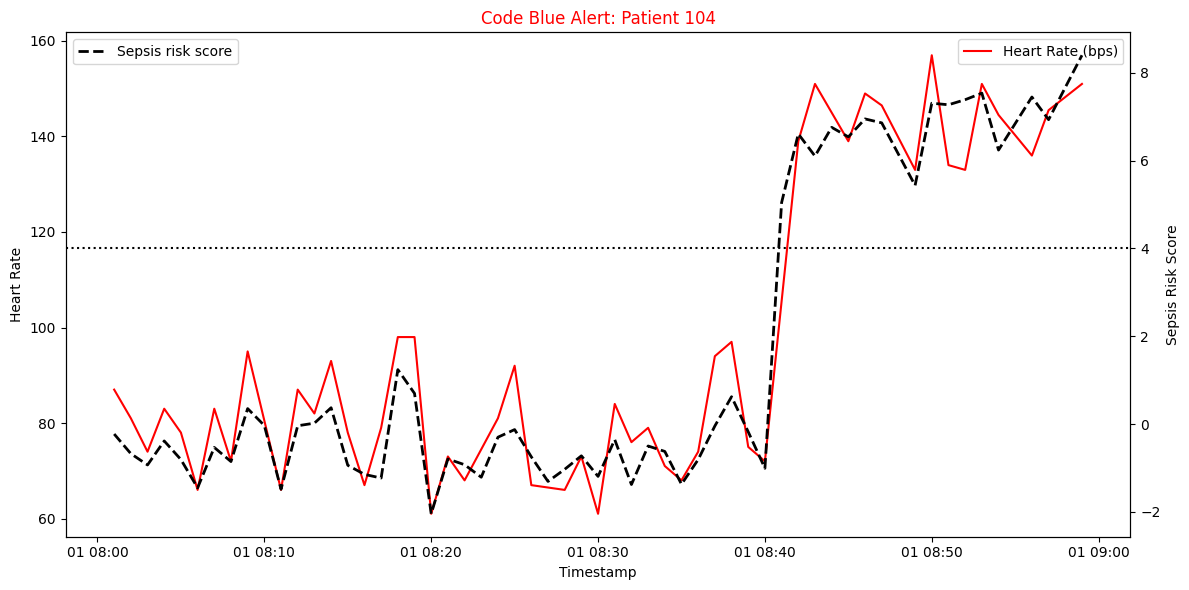

In [189]:
fig , ax1 = plt.subplots(figsize=(12,6))
ax1.plot(patient_data["Timestamp"], patient_data["HR"], color = 'red', label="Heart Rate (bps)")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Heart Rate")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(patient_data["Timestamp"], patient_data["Total_Risk"], linestyle = '--', color ='black' , label = 'Sepsis risk score' , linewidth=2)
ax2.set_ylabel("Sepsis Risk Score", color="black")
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend()

ax2.axhline(y=4.0 ,color = 'black' , linestyle = ':' , linewidth = 1.5)
plt.title("Code Blue Alert: Patient 104" , color = 'red')
plt.tight_layout()

plt.show()

In [191]:
merged_df = merged_df.reset_index()
merged_df= merged_df.sort_values("Total_Risk", ascending=False)
print("Patient ID : ", merged_df["Patient_ID"].iloc[0])
print("Timestamp : ", merged_df["Timestamp"].iloc[0])


Patient ID :  104
Timestamp :  2025-01-01 08:59:00
